5) Exploratory Data Analysis

(plots for weather_global_dataset.csv, and modifing both the Data_cleaned and weatehr_global_dataset.csv)

Shape: (206784, 35)
                  time  temperature_2m (°C)  relative_humidity_2m (%)  \
0  2024-01-03 00:00:00                 21.7                        88   
1  2024-01-03 01:00:00                 22.0                        89   
2  2024-01-03 02:00:00                 22.8                        86   
3  2024-01-03 03:00:00                 24.6                        80   
4  2024-01-03 04:00:00                 26.4                        72   

   rain (mm)  surface_pressure (hPa)  wind_speed_10m (km/h)  \
0        0.0                  1003.1                   10.8   
1        0.0                  1003.9                   11.5   
2        0.0                  1004.8                   11.2   
3        0.0                  1005.5                   13.0   
4        0.0                  1005.8                   15.0   

   wind_speed_100m (km/h)  wind_direction_100m (°)  wind_direction_10m (°)  \
0                    21.8                        8                       2   
1     

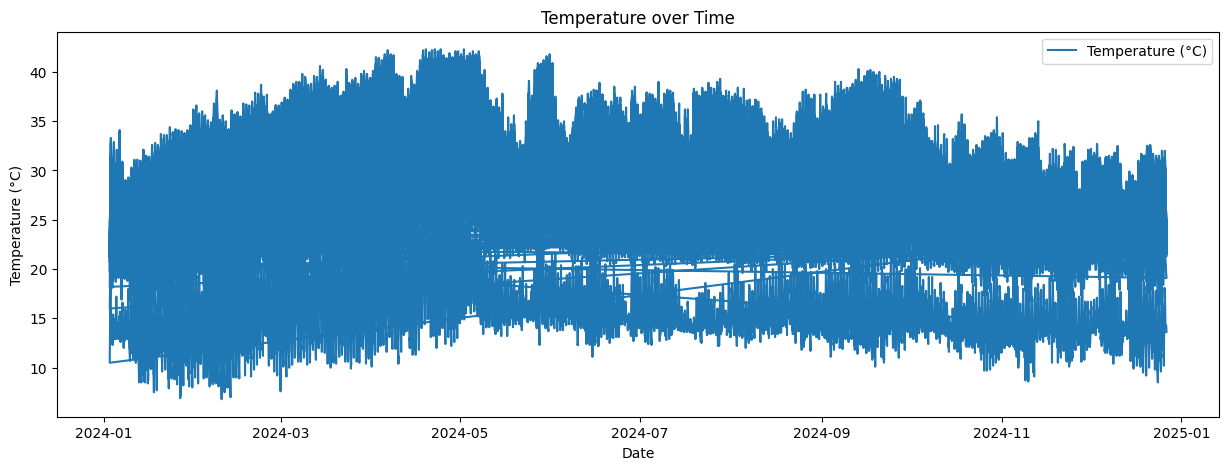

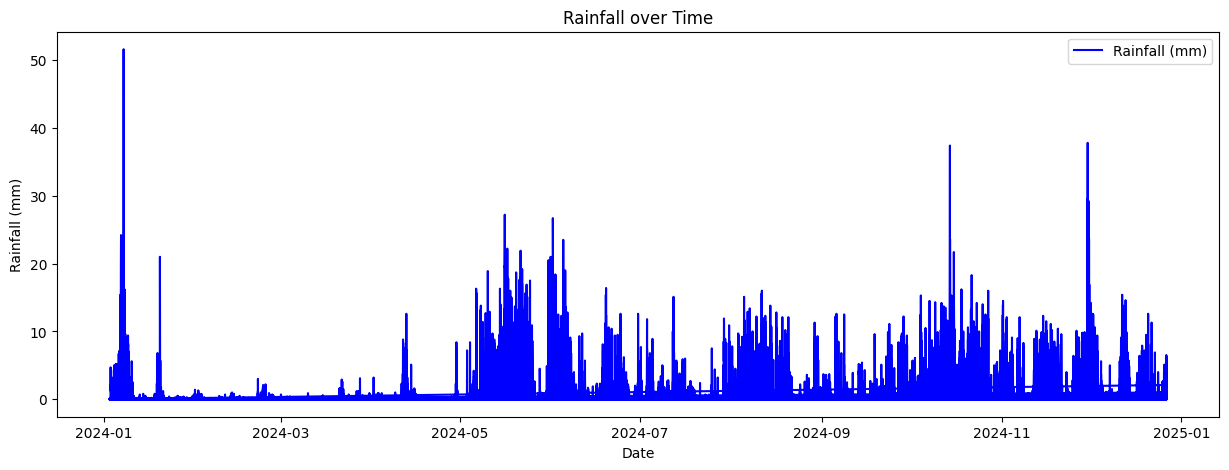

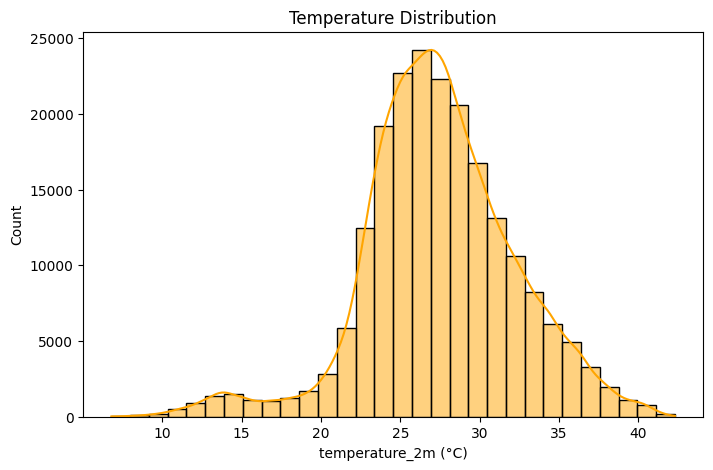

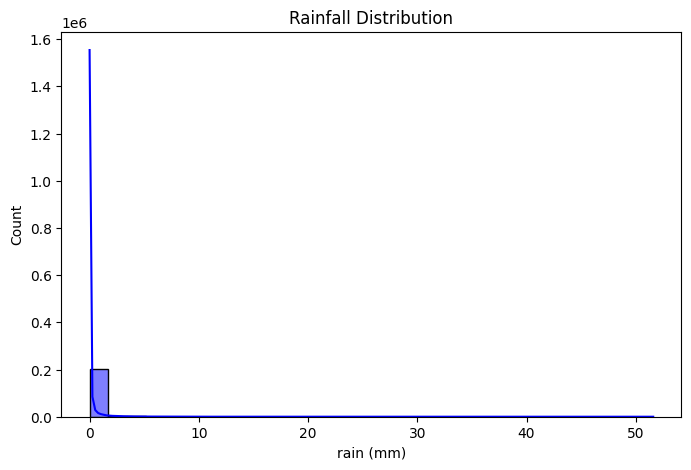

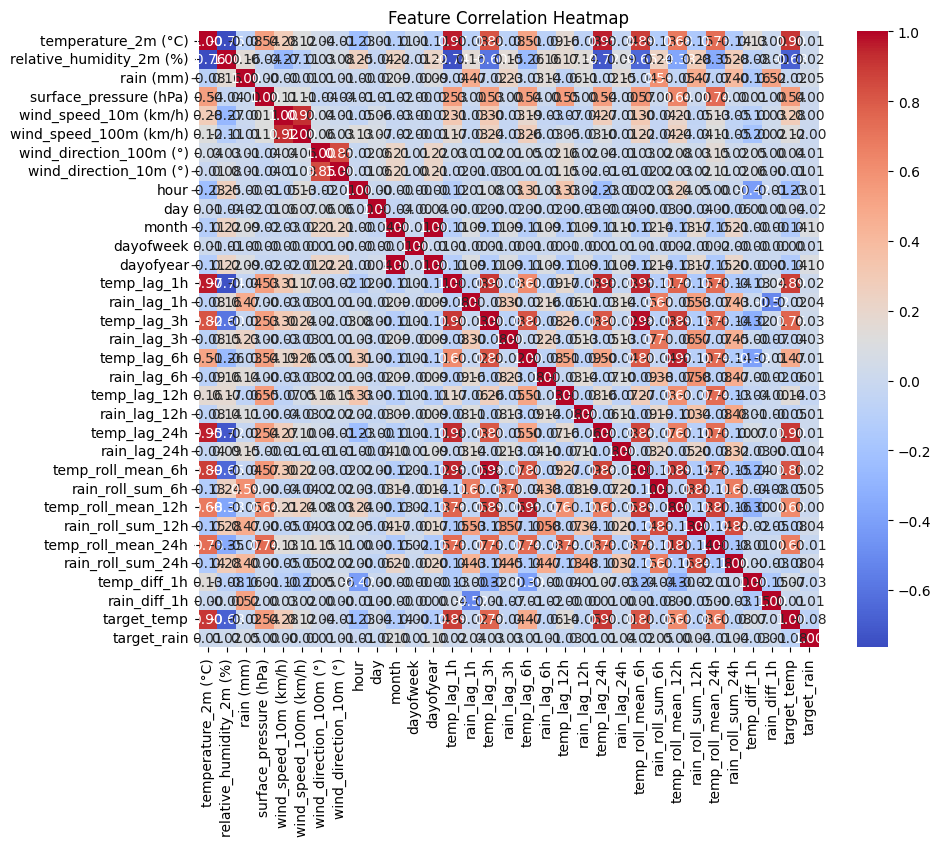

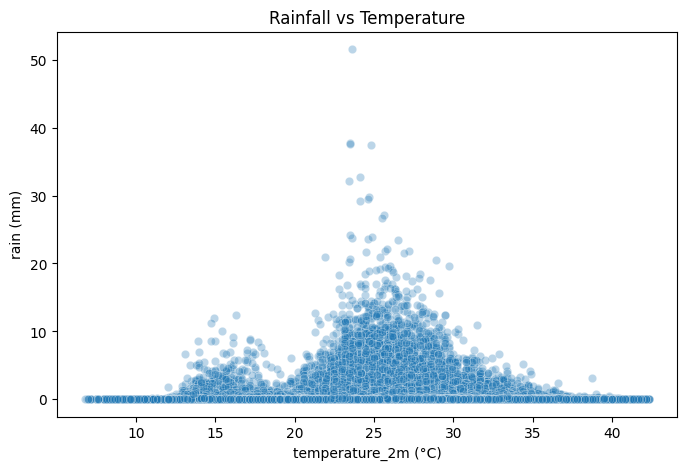

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_global = pd.read_csv("weather_global_dataset.csv")

print("Shape:", df_global.shape)
print(df_global.head())

# Step 2: EDA Plots
plt.figure(figsize=(15, 5))
plt.plot(pd.to_datetime(df_global['time']), df_global['temperature_2m (°C)'], label='Temperature (°C)')
plt.title("Temperature over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(pd.to_datetime(df_global['time']), df_global['rain (mm)'], color='blue', label='Rainfall (mm)')
plt.title("Rainfall over Time")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()

# Temperature Distribution
plt.figure(figsize=(8,5))
sns.histplot(df_global['temperature_2m (°C)'], kde=True, bins=30, color='orange')
plt.title("Temperature Distribution")
plt.show()

# Rainfall Distribution
plt.figure(figsize=(8,5))
sns.histplot(df_global['rain (mm)'], kde=True, bins=30, color='blue')
plt.title("Rainfall Distribution")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_global.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Scatter: Rainfall vs Temperature
plt.figure(figsize=(8,5))
sns.scatterplot(x='temperature_2m (°C)', y='rain (mm)', data=df_global, alpha=0.3)
plt.title("Rainfall vs Temperature")
plt.show()


Local summary in text

In [3]:
def quick_summary(df):
    summary = {}
    summary['Temp_min'] = df['temperature_2m (°C)'].min()
    summary['Temp_max'] = df['temperature_2m (°C)'].max()
    summary['Temp_mean'] = df['temperature_2m (°C)'].mean()

    summary['Rain_min'] = df['rain (mm)'].min()
    summary['Rain_max'] = df['rain (mm)'].max()
    summary['Rain_mean'] = df['rain (mm)'].mean()

    summary['Correlation_temp_rain'] = df[['temperature_2m (°C)', 'rain (mm)']].corr().iloc[0,1]
    return summary

print("📊 Quick Dataset Summary:")
print(quick_summary(df_global))

# Example correlation with other features
print("\n🔗 Correlation Matrix (first few):")
print(df_global.corr(numeric_only=True).round(2).head())

📊 Quick Dataset Summary:
{'Temp_min': np.float64(6.8), 'Temp_max': np.float64(42.3), 'Temp_mean': np.float64(27.457182373878055), 'Rain_min': np.float64(0.0), 'Rain_max': np.float64(51.6), 'Rain_mean': np.float64(0.1756044955122253), 'Correlation_temp_rain': np.float64(-0.08210501852502237)}

🔗 Correlation Matrix (first few):
                          temperature_2m (°C)  relative_humidity_2m (%)  \
temperature_2m (°C)                      1.00                     -0.76   
relative_humidity_2m (%)                -0.76                      1.00   
rain (mm)                               -0.08                      0.16   
surface_pressure (hPa)                   0.54                     -0.04   
wind_speed_10m (km/h)                    0.28                     -0.27   

                          rain (mm)  surface_pressure (hPa)  \
temperature_2m (°C)           -0.08                    0.54   
relative_humidity_2m (%)       0.16                   -0.04   
rain (mm)                      1

Train/Validation Split (Chronological)

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

# Sort by time if not already
df_global = df_global.sort_values("time")

# Define train size (80% train, 20% validation)
train_size = int(len(df_global) * 0.8)

train_df = df_global.iloc[:train_size]
val_df = df_global.iloc[train_size:]

print(f"Train set: {train_df.shape}, Validation set: {val_df.shape}")


Train set: (165427, 35), Validation set: (41357, 35)


Since LightGBM first, no scaling needed here.
We’ll keep this step ready if we later go for LSTM.

Model Input/Output Setup

In [5]:
# Features to drop from X
drop_cols = ["time", "target_temp", "target_rain"]  # Drop time and target columns

# Training Data
X_train = train_df.drop(columns=drop_cols)
y_train_temp = train_df["target_temp"]
y_train_rain = train_df["target_rain"]

# Validation Data
X_val = val_df.drop(columns=drop_cols)
y_val_temp = val_df["target_temp"]
y_val_rain = val_df["target_rain"]

print("Features used for training:", X_train.columns.tolist())

Features used for training: ['temperature_2m (°C)', 'relative_humidity_2m (%)', 'rain (mm)', 'surface_pressure (hPa)', 'wind_speed_10m (km/h)', 'wind_speed_100m (km/h)', 'wind_direction_100m (°)', 'wind_direction_10m (°)', 'hour', 'day', 'month', 'dayofweek', 'dayofyear', 'temp_lag_1h', 'rain_lag_1h', 'temp_lag_3h', 'rain_lag_3h', 'temp_lag_6h', 'rain_lag_6h', 'temp_lag_12h', 'rain_lag_12h', 'temp_lag_24h', 'rain_lag_24h', 'temp_roll_mean_6h', 'rain_roll_sum_6h', 'temp_roll_mean_12h', 'rain_roll_sum_12h', 'temp_roll_mean_24h', 'rain_roll_sum_24h', 'temp_diff_1h', 'rain_diff_1h', 'district']


LightGBM Training + Feature Importance

Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 1.42548	valid_1's rmse: 1.62646
Early stopping, best iteration is:
[48]	training's rmse: 1.43532	valid_1's rmse: 1.62128
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4]	training's rmse: 0.765949	valid_1's rmse: 1.07501


<Figure size 1200x600 with 0 Axes>

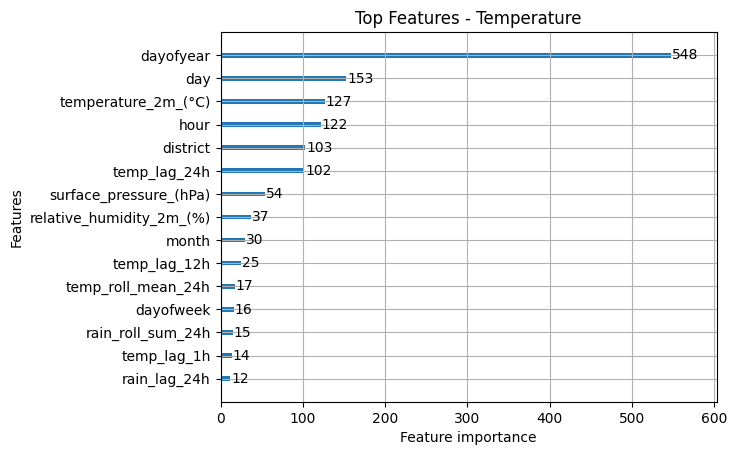

<Figure size 1200x600 with 0 Axes>

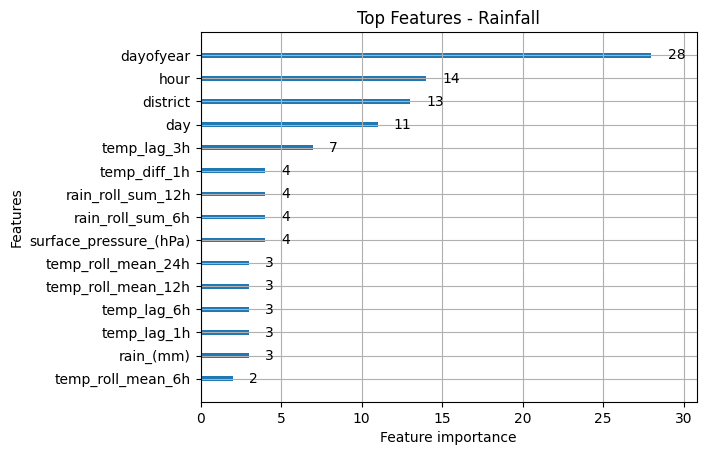

Top Features for Temperature Prediction: [('dayofyear', np.int32(548)), ('day', np.int32(153)), ('temperature_2m_(°C)', np.int32(127)), ('hour', np.int32(122)), ('district', np.int32(103)), ('temp_lag_24h', np.int32(102)), ('surface_pressure_(hPa)', np.int32(54)), ('relative_humidity_2m_(%)', np.int32(37)), ('month', np.int32(30)), ('temp_lag_12h', np.int32(25))]
Top Features for Rainfall Prediction: [('dayofyear', np.int32(28)), ('hour', np.int32(14)), ('district', np.int32(13)), ('day', np.int32(11)), ('temp_lag_3h', np.int32(7)), ('surface_pressure_(hPa)', np.int32(4)), ('rain_roll_sum_6h', np.int32(4)), ('rain_roll_sum_12h', np.int32(4)), ('temp_diff_1h', np.int32(4)), ('rain_(mm)', np.int32(3))]


In [9]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'district' is categorical before creating LightGBM datasets
X_train['district'] = X_train['district'].astype('category')
X_val['district'] = X_val['district'].astype('category')

# Train model for temperature
lgb_train_temp = lgb.Dataset(X_train, label=y_train_temp)
lgb_val_temp = lgb.Dataset(X_val, label=y_val_temp, reference=lgb_train_temp)

params_temp = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt'
}

model_temp = lgb.train(
    params_temp,
    lgb_train_temp,
    valid_sets=[lgb_train_temp, lgb_val_temp],
    num_boost_round=200,
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(period=50)
    ]
)

# Train model for rainfall
lgb_train_rain = lgb.Dataset(X_train, label=y_train_rain)
lgb_val_rain = lgb.Dataset(X_val, label=y_val_rain, reference=lgb_train_rain)

params_rain = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt'
}

model_rain = lgb.train(
    params_rain,
    lgb_train_rain,
    valid_sets=[lgb_train_rain, lgb_val_rain],
    num_boost_round=200,
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(period=50)
    ]
)

# Feature importance plots
plt.figure(figsize=(12, 6))
lgb.plot_importance(model_temp, max_num_features=15, title="Top Features - Temperature")
plt.show()

plt.figure(figsize=(12, 6))
lgb.plot_importance(model_rain, max_num_features=15, title="Top Features - Rainfall")
plt.show()

# Text summary for me
feat_imp_temp = sorted(zip(model_temp.feature_name(), model_temp.feature_importance()), key=lambda x: x[1], reverse=True)
feat_imp_rain = sorted(zip(model_rain.feature_name(), model_rain.feature_importance()), key=lambda x: x[1], reverse=True)

print("Top Features for Temperature Prediction:", feat_imp_temp[:10])
print("Top Features for Rainfall Prediction:", feat_imp_rain[:10])

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Check variable existence before running
print(X_val.shape, y_val_temp.shape, y_val_rain.shape)
print(model_temp, model_rain)

(41357, 32) (41357,) (41357,)
<lightgbm.basic.Booster object at 0x000001CB6CC71CA0> <lightgbm.basic.Booster object at 0x000001CB6CC710A0>


Evaluate both temperature and rainfall models using RMSE, MAE, and R² - Model Evaluation

Plot predicted vs actual values for validation set - Model Prediction

Save the trained models to disk for future use

📊 Temperature Model Performance:
RMSE: 1.621, MAE: 1.246, R²: 0.801

🌧 Rainfall Model Performance:
RMSE: 1.075, MAE: 0.403, R²: -0.006


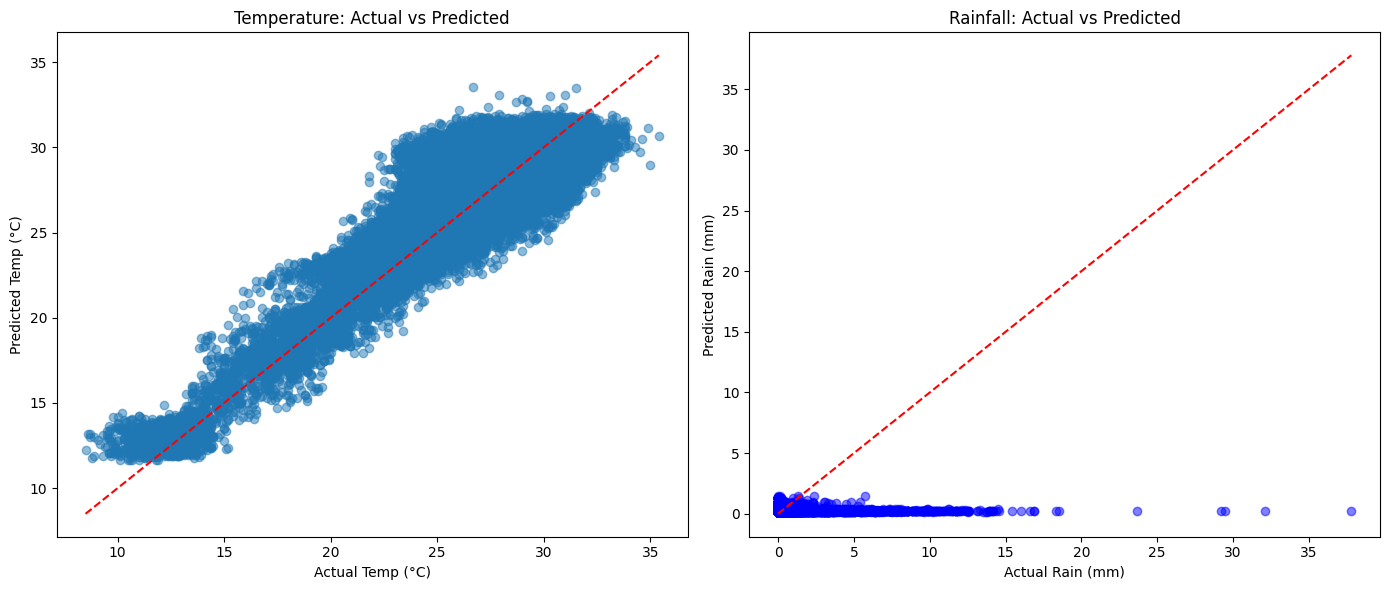

✅ Models saved: temperature_model_lgbm.pkl, rainfall_model_lgbm.pkl


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import numpy as np

# --- Step 9 & 10: Evaluation and Prediction ---

# Predictions
y_pred_temp = model_temp.predict(X_val)
y_pred_rain = model_rain.predict(X_val)

# Metrics for Temperature
rmse_temp = np.sqrt(mean_squared_error(y_val_temp, y_pred_temp))
mae_temp = mean_absolute_error(y_val_temp, y_pred_temp)
r2_temp = r2_score(y_val_temp, y_pred_temp)

# Metrics for Rainfall
rmse_rain = np.sqrt(mean_squared_error(y_val_rain, y_pred_rain))
mae_rain = mean_absolute_error(y_val_rain, y_pred_rain)
r2_rain = r2_score(y_val_rain, y_pred_rain)

print("📊 Temperature Model Performance:")
print(f"RMSE: {rmse_temp:.3f}, MAE: {mae_temp:.3f}, R²: {r2_temp:.3f}")
print("\n🌧 Rainfall Model Performance:")
print(f"RMSE: {rmse_rain:.3f}, MAE: {mae_rain:.3f}, R²: {r2_rain:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Temp plot
axes[0].scatter(y_val_temp, y_pred_temp, alpha=0.5)
axes[0].plot([y_val_temp.min(), y_val_temp.max()],
             [y_val_temp.min(), y_val_temp.max()],
             'r--')
axes[0].set_title("Temperature: Actual vs Predicted")
axes[0].set_xlabel("Actual Temp (°C)")
axes[0].set_ylabel("Predicted Temp (°C)")

# Rain plot
axes[1].scatter(y_val_rain, y_pred_rain, alpha=0.5, color='blue')
axes[1].plot([y_val_rain.min(), y_val_rain.max()],
             [y_val_rain.min(), y_val_rain.max()],
             'r--')
axes[1].set_title("Rainfall: Actual vs Predicted")
axes[1].set_xlabel("Actual Rain (mm)")
axes[1].set_ylabel("Predicted Rain (mm)")

plt.tight_layout()
plt.show()

joblib.dump(model_temp, "temperature_model_lgbm.pkl")
joblib.dump(model_rain, "rainfall_model_lgbm.pkl")
print("✅ Models saved: temperature_model_lgbm.pkl, rainfall_model_lgbm.pkl")


Summarizing the graph

In [15]:
import numpy as np
import pandas as pd

def summarize_actual_vs_predicted(y_true, y_pred, label):
    diff = y_true - y_pred
    summary = {
        "Label": label,
        "Count": len(y_true),
        "Min Actual": np.min(y_true),
        "Max Actual": np.max(y_true),
        "Min Predicted": np.min(y_pred),
        "Max Predicted": np.max(y_pred),
        "Mean Absolute Error": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred),
        "Mean Diff (Actual - Pred)": np.mean(diff),
        "Std Dev Diff": np.std(diff)
    }
    return summary

# Summarize both graphs
summary_temp = summarize_actual_vs_predicted(y_val_temp, y_pred_temp, "Temperature")
summary_rain = summarize_actual_vs_predicted(y_val_rain, y_pred_rain, "Rainfall")

# Convert to DataFrame for easy reading
summary_df = pd.DataFrame([summary_temp, summary_rain])
print(summary_df.to_string(index=False))

      Label  Count  Min Actual  Max Actual  Min Predicted  Max Predicted  Mean Absolute Error     RMSE        R²  Mean Diff (Actual - Pred)  Std Dev Diff
Temperature  41357         8.5        35.4      11.668454      33.519590             1.245926 1.621275  0.801037                  -0.430696      1.563021
   Rainfall  41357         0.0        37.8       0.180627       1.455446             0.403128 1.075011 -0.005625                   0.060206      1.073323


In [16]:
from scipy.stats import pearsonr
import numpy as np

def summarize_actual_vs_predicted(y_actual, y_pred, label=""):
    # Calculate stats
    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    r2 = r2_score(y_actual, y_pred)
    corr, _ = pearsonr(y_actual, y_pred)
    
    # Print summary
    print(f"📊 Summary for {label}")
    print(f"  MAE:  {mae:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  R²:   {r2:.3f}")
    print(f"  Correlation (Pearson r): {corr:.3f}")
    
    # Trend interpretation
    if corr > 0.9:
        trend = "Very strong positive correlation — predictions match closely."
    elif corr > 0.75:
        trend = "Strong positive correlation — good fit."
    elif corr > 0.5:
        trend = "Moderate positive correlation — decent but room for improvement."
    elif corr > 0.25:
        trend = "Weak positive correlation — model struggles."
    else:
        trend = "Very weak or no correlation — model is poor."
    
    print(f"  Trend: {trend}")
    print("-" * 50)

# Example usage after your predictions
summarize_actual_vs_predicted(y_val_temp, y_pred_temp, label="Temperature Prediction")
summarize_actual_vs_predicted(y_val_rain, y_pred_rain, label="Rainfall Prediction")

📊 Summary for Temperature Prediction
  MAE:  1.246
  RMSE: 1.621
  R²:   0.801
  Correlation (Pearson r): 0.904
  Trend: Very strong positive correlation — predictions match closely.
--------------------------------------------------
📊 Summary for Rainfall Prediction
  MAE:  0.403
  RMSE: 1.075
  R²:   -0.006
  Correlation (Pearson r): 0.019
  Trend: Very weak or no correlation — model is poor.
--------------------------------------------------


best possible rainfall accuracy, go LSTM/TCN now instead of trying incremental tweaks to LightGBM.

We can keep LightGBM for temperature (since it’s performing well) and use a separate sequence model just for rainfall.

In [18]:
print(df_global.columns)

Index(['time', 'temperature_2m (°C)', 'relative_humidity_2m (%)', 'rain (mm)',
       'surface_pressure (hPa)', 'wind_speed_10m (km/h)',
       'wind_speed_100m (km/h)', 'wind_direction_100m (°)',
       'wind_direction_10m (°)', 'hour', 'day', 'month', 'dayofweek',
       'dayofyear', 'temp_lag_1h', 'rain_lag_1h', 'temp_lag_3h', 'rain_lag_3h',
       'temp_lag_6h', 'rain_lag_6h', 'temp_lag_12h', 'rain_lag_12h',
       'temp_lag_24h', 'rain_lag_24h', 'temp_roll_mean_6h', 'rain_roll_sum_6h',
       'temp_roll_mean_12h', 'rain_roll_sum_12h', 'temp_roll_mean_24h',
       'rain_roll_sum_24h', 'temp_diff_1h', 'rain_diff_1h', 'district',
       'target_temp', 'target_rain'],
      dtype='object')


In [19]:
import pandas as pd
import numpy as np

def rainfall_data_insights(df, target_col='rain (mm)', time_col='time'):
    insights = {}

    # --- Basic statistics ---
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    insights['count'] = df[target_col].count()
    insights['mean'] = df[target_col].mean()
    insights['std'] = df[target_col].std()
    insights['min'] = df[target_col].min()
    insights['max'] = df[target_col].max()
    insights['median'] = df[target_col].median()
    insights['zero_count'] = (df[target_col] == 0).sum()
    insights['zero_pct'] = (insights['zero_count'] / len(df)) * 100
    insights['nonzero_min'] = df.loc[df[target_col] > 0, target_col].min()
    insights['nonzero_max'] = df.loc[df[target_col] > 0, target_col].max()
    insights['nonzero_mean'] = df.loc[df[target_col] > 0, target_col].mean()

    # --- Seasonality check ---
    if time_col in df.columns:
        # Convert to datetime if not already
        if not pd.api.types.is_datetime64_any_dtype(df[time_col]):
            df[time_col] = pd.to_datetime(df[time_col], errors='coerce')

        if pd.api.types.is_datetime64_any_dtype(df[time_col]):
            df['month'] = df[time_col].dt.month
            monthly_avg = df.groupby('month')[target_col].mean()
            insights['monthly_avg'] = monthly_avg.to_dict()

    # --- Correlation with temperature ---
    temp_col = [c for c in df.columns if 'temp' in c.lower()]
    if temp_col:
        corr = df[target_col].corr(df[temp_col[0]])
        insights['corr_with_temp'] = corr

    return insights


# Example run
rain_insights = rainfall_data_insights(df_global, target_col='rain (mm)', time_col='time')

for k, v in rain_insights.items():
    print(f"{k}: {v}")


count: 206784
mean: 0.1756044955122253
std: 0.886968705405081
min: 0.0
max: 51.6
median: 0.0
zero_count: 167741
zero_pct: 81.11894537294955
nonzero_min: 0.1
nonzero_max: 51.6
nonzero_mean: 0.9300566042568449
monthly_avg: {1: 0.12945402298850575, 2: 0.010356800766283526, 3: 0.0058915770609318996, 4: 0.02288773148148148, 5: 0.333820564516129, 6: 0.2070775462962963, 7: 0.12267025089605735, 8: 0.21712589605734767, 9: 0.08482060185185185, 10: 0.3484262992831541, 11: 0.35859375, 12: 0.26615918803418803}
corr_with_temp: -0.08210501852502274


Data is extremely imbalanced — ~81% of all time points have 0 mm rainfall.

Non-zero rainfall averages only ~0.93 mm, so heavy rains are rare but can go up to 51.6 mm.

Seasonality — Peaks in rainfall occur in May, October, and November, suggesting monsoon influence.

Temperature correlation is slightly negative (-0.082), meaning temperature is not a strong predictor for rainfall amount directly.

For rainfall, a two-step approach should work better:

Rain occurrence model (classification: will it rain or not?).

Rain amount model (regression: how much rain, if rain > 0).

The occurrence model could be CatBoost Classifier (handles imbalance and categorical data well).

The amount model could be Quantile Regression LGBM or an LSTM to capture temporal patterns.

In [20]:
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report
import numpy as np
import joblib


Create rain occurrence label

In [21]:
df_global['rain_occurrence'] = (df_global['target_rain'] > 0).astype(int)

# Feature columns (excluding targets)
features = [
    'temperature_2m (°C)', 'relative_humidity_2m (%)', 'rain (mm)',
    'surface_pressure (hPa)', 'wind_speed_10m (km/h)', 'wind_speed_100m (km/h)',
    'wind_direction_100m (°)', 'wind_direction_10m (°)', 'hour', 'day', 'month',
    'dayofweek', 'dayofyear', 'temp_lag_1h', 'rain_lag_1h', 'temp_lag_3h', 'rain_lag_3h',
    'temp_lag_6h', 'rain_lag_6h', 'temp_lag_12h', 'rain_lag_12h', 'temp_lag_24h',
    'rain_lag_24h', 'temp_roll_mean_6h', 'rain_roll_sum_6h', 'temp_roll_mean_12h',
    'rain_roll_sum_12h', 'temp_roll_mean_24h', 'rain_roll_sum_24h',
    'temp_diff_1h', 'rain_diff_1h', 'district'
]

# Ensure 'district' is categorical
df_global['district'] = df_global['district'].astype('category')

Train CatBoost Classifier (Rain Occurrence)

In [22]:
X_train_cls, X_val_cls, y_train_cls, y_val_cls = train_test_split(
    df_global[features], df_global['rain_occurrence'], test_size=0.2, random_state=42
)

cat_features = ['district']

cls_model = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='Accuracy',
    verbose=100,
    class_weights=[1, 5],  # handle imbalance
    cat_features=cat_features
)

cls_model.fit(X_train_cls, y_train_cls, eval_set=(X_val_cls, y_val_cls))

# Classification performance
y_pred_cls = cls_model.predict(X_val_cls)
print(classification_report(y_val_cls, y_pred_cls))

0:	learn: 0.6869758	test: 0.6840312	best: 0.6840312 (0)	total: 288ms	remaining: 2m 23s
100:	learn: 0.7701909	test: 0.7701731	best: 0.7701731 (100)	total: 13.7s	remaining: 54.3s
200:	learn: 0.7920089	test: 0.7883838	best: 0.7883838 (200)	total: 27s	remaining: 40.2s
300:	learn: 0.8092210	test: 0.8017797	best: 0.8017797 (300)	total: 40.7s	remaining: 26.9s
400:	learn: 0.8224623	test: 0.8101538	best: 0.8102366 (399)	total: 54.2s	remaining: 13.4s
499:	learn: 0.8329484	test: 0.8155756	best: 0.8156584 (496)	total: 1m 7s	remaining: 0us

bestTest = 0.8156584121
bestIteration = 496

Shrink model to first 497 iterations.
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     33575
           1       0.45      0.87      0.59      7782

    accuracy                           0.78     41357
   macro avg       0.71      0.81      0.72     41357
weighted avg       0.87      0.78      0.80     41357



Train Rain Amount Model (only on rainy cases)

In [23]:
rainy_df = df_global[df_global['rain_occurrence'] == 1]

X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    rainy_df[features], rainy_df['target_rain'], test_size=0.2, random_state=42
)

lgb_train_rain = lgb.Dataset(X_train_reg, label=y_train_reg, categorical_feature=['district'])
lgb_val_rain = lgb.Dataset(X_val_reg, label=y_val_reg, reference=lgb_train_rain)

params_rain = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31
}

reg_model = lgb.train(
    params_rain,
    lgb_train_rain,
    valid_sets=[lgb_train_rain, lgb_val_rain],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=50)
    ]
)

Training until validation scores don't improve for 30 rounds
[50]	training's rmse: 1.62284	valid_1's rmse: 1.64587
[100]	training's rmse: 1.54446	valid_1's rmse: 1.62731
[150]	training's rmse: 1.49065	valid_1's rmse: 1.61763
[200]	training's rmse: 1.4488	valid_1's rmse: 1.61406
[250]	training's rmse: 1.41146	valid_1's rmse: 1.61045
[300]	training's rmse: 1.37384	valid_1's rmse: 1.60753
[350]	training's rmse: 1.34164	valid_1's rmse: 1.60576
Early stopping, best iteration is:
[348]	training's rmse: 1.34281	valid_1's rmse: 1.60568


Combine Predictions

In [24]:
rain_occ_pred = cls_model.predict(X_val_cls)  # 0 or 1
rain_amt_pred = reg_model.predict(X_val_cls)  # continuous

final_rain_pred = np.where(rain_occ_pred == 1, rain_amt_pred, 0)

Evaluate Full Pipeline

In [25]:
# rmse_rain = mean_squared_error(y_val_cls.replace(1, y_val_reg.mean()), final_rain_pred, squared=False)
rmse_rain = np.sqrt(mean_squared_error(pd.Series(y_val_cls).replace(1, y_val_reg.mean()), final_rain_pred))
mae_rain = mean_absolute_error(y_val_cls.replace(1, y_val_reg.mean()), final_rain_pred)
r2_rain = r2_score(y_val_cls.replace(1, y_val_reg.mean()), final_rain_pred)

print("Final Rainfall Prediction Performance:")
print(f"RMSE: {rmse_rain:.3f}, MAE: {mae_rain:.3f}, R²: {r2_rain:.3f}")

# Save models
joblib.dump(cls_model, "rain_occurrence_model_catboost.pkl")
joblib.dump(reg_model, "rain_amount_model_lgbm.pkl")
print("✅ Models saved: rain_occurrence_model_catboost.pkl, rain_amount_model_lgbm.pkl")

Final Rainfall Prediction Performance:
RMSE: 0.555, MAE: 0.260, R²: -1.543
✅ Models saved: rain_occurrence_model_catboost.pkl, rain_amount_model_lgbm.pkl


quantile regression + log-transform hybrid


In [27]:
# --- Prepare data for rainfall amount regression ---
# Use only rows where rainfall actually occurred
mask_rain = y_train_rain > 0
X_train_rain_amount = X_train[mask_rain].copy()
y_train_rain_amount = np.log1p(y_train_rain[mask_rain])  # log-transform to handle skewness

mask_rain_val = y_val_rain > 0
X_val_rain_amount = X_val[mask_rain_val].copy()
y_val_rain_amount = np.log1p(y_val_rain[mask_rain_val])

# --- LightGBM Quantile Regression ---
params_rain_q = {
    'objective': 'quantile',
    'alpha': 0.5,  # median regression
    'metric': 'quantile',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

lgb_train_rain_q = lgb.Dataset(X_train_rain_amount, label=y_train_rain_amount)
lgb_val_rain_q = lgb.Dataset(X_val_rain_amount, label=y_val_rain_amount, reference=lgb_train_rain_q)

model_rain_amount = lgb.train(
    params_rain_q,
    lgb_train_rain_q,
    valid_sets=[lgb_train_rain_q, lgb_val_rain_q],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=50)
    ]
)

# --- Evaluate ---
y_pred_rain_amount = np.expm1(model_rain_amount.predict(X_val_rain_amount))  # reverse log transform

# rmse_rain_amount = mean_squared_error(y_val_rain[mask_rain_val], y_pred_rain_amount, squared=False)
rmse_rain_amount = np.sqrt(mean_squared_error(y_val_rain[mask_rain_val], y_pred_rain_amount))
mae_rain_amount = mean_absolute_error(y_val_rain[mask_rain_val], y_pred_rain_amount)
r2_rain_amount = r2_score(y_val_rain[mask_rain_val], y_pred_rain_amount)

print("\n🌧 Rainfall Amount Model (Quantile Regression) Performance:")
print(f"RMSE: {rmse_rain_amount:.3f}, MAE: {mae_rain_amount:.3f}, R²: {r2_rain_amount:.3f}")

# Save model
joblib.dump(model_rain_amount, "rain_amount_model_lgbm_quantile.pkl")
print("✅ Quantile regression model saved: rain_amount_model_lgbm_quantile.pkl")


Training until validation scores don't improve for 30 rounds
[50]	training's quantile: 0.151379	valid_1's quantile: 0.17586
Early stopping, best iteration is:
[41]	training's quantile: 0.152469	valid_1's quantile: 0.175118

🌧 Rainfall Amount Model (Quantile Regression) Performance:
RMSE: 1.894, MAE: 0.812, R²: -0.126
✅ Quantile regression model saved: rain_amount_model_lgbm_quantile.pkl


Rainfall: No, Light, Moderate, Heavy

In [29]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import joblib

# --- 1️⃣ Create Rainfall Categories ---
# New: Merge moderate & heavy, shrink light threshold
def categorize_rain(rain_mm):
    if rain_mm == 0:
        return 0  # No rain
    elif rain_mm <= 1.5:
        return 1  # Light
    else:
        return 2  # Moderate-Heavy (merged)
    
# Apply new categorization
y_train_rain_cat = y_train_rain.apply(categorize_rain)
y_val_rain_cat = y_val_rain.apply(categorize_rain)

# --- 2️⃣ Train CatBoost Classifier ---
train_pool_cat = Pool(X_train, y_train_rain_cat, cat_features=['district'])
val_pool_cat = Pool(X_val, y_val_rain_cat, cat_features=['district'])

model_rain_cat = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.05,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=50
)

model_rain_cat.fit(train_pool_cat, eval_set=val_pool_cat, early_stopping_rounds=30)

# --- 3️⃣ Evaluate ---
y_pred_rain_cat = model_rain_cat.predict(X_val)
print("\n🌧 Rainfall Category Prediction Report:")
print(classification_report(y_val_rain_cat, y_pred_rain_cat, target_names=["No rain", "Light", "Moderate-Heavy"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val_rain_cat, y_pred_rain_cat))

# --- 4️⃣ Save model ---
joblib.dump(model_rain_cat, "rainfall_category_model_catboost.pkl")
print("✅ Rainfall category model saved: rainfall_category_model_catboost.pkl")


0:	learn: 0.7821050	test: 0.5875223	best: 0.5875223 (0)	total: 223ms	remaining: 1m 51s
50:	learn: 0.7919436	test: 0.6151187	best: 0.6160589 (48)	total: 11.3s	remaining: 1m 39s
100:	learn: 0.8051758	test: 0.6226717	best: 0.6234404 (73)	total: 22.1s	remaining: 1m 27s
150:	learn: 0.8135974	test: 0.6238468	best: 0.6246140 (136)	total: 32.8s	remaining: 1m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6246139545
bestIteration = 136

Shrink model to first 137 iterations.

🌧 Rainfall Category Prediction Report:
                precision    recall  f1-score   support

       No rain       0.74      0.81      0.77     28914
         Light       0.36      0.33      0.34     10360
Moderate-Heavy       0.00      0.00      0.00      2083

      accuracy                           0.65     41357
     macro avg       0.36      0.38      0.37     41357
  weighted avg       0.60      0.65      0.62     41357


Confusion Matrix:
[[23366  5548     0]
 [ 6929  3431     0]
 [ 1465  

d:\Academics\AI\virt\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Academics\AI\virt\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Academics\AI\virt\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


a single model to categorize and predict the amount of rain

In [30]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
import numpy as np
import joblib

# --- Custom Wrapper Class ---
class RainfallPredictor:
    def __init__(self):
        self.category_model = None
        self.amount_model = None

    def categorize_rain(self, rain_mm):
        if rain_mm == 0:
            return 0  # No rain
        elif rain_mm <= 1.5:
            return 1  # Light
        else:
            return 2  # Moderate-Heavy

    def train(self, X_train, y_train_amount, X_val, y_val_amount, cat_features):
        # --- Prepare category targets ---
        y_train_cat = y_train_amount.apply(self.categorize_rain)
        y_val_cat = y_val_amount.apply(self.categorize_rain)

        # --- Train Category Model ---
        train_pool_cat = Pool(X_train, y_train_cat, cat_features=cat_features)
        val_pool_cat = Pool(X_val, y_val_cat, cat_features=cat_features)

        self.category_model = CatBoostClassifier(
            iterations=500,
            depth=8,
            learning_rate=0.05,
            loss_function='MultiClass',
            eval_metric='TotalF1',
            random_seed=42,
            verbose=50
        )
        self.category_model.fit(train_pool_cat, eval_set=val_pool_cat, early_stopping_rounds=30)

        # --- Train Amount Model (Regression) ---
        train_pool_amt = Pool(X_train, y_train_amount, cat_features=cat_features)
        val_pool_amt = Pool(X_val, y_val_amount, cat_features=cat_features)

        self.amount_model = CatBoostRegressor(
            iterations=500,
            depth=8,
            learning_rate=0.05,
            loss_function='RMSE',
            random_seed=42,
            verbose=50
        )
        self.amount_model.fit(train_pool_amt, eval_set=val_pool_amt, early_stopping_rounds=30)

        # --- Evaluation ---
        # Category
        y_pred_cat = self.category_model.predict(X_val)
        print("\n🌧 Rainfall Category Prediction Report:")
        print(classification_report(y_val_cat, y_pred_cat, target_names=["No rain", "Light", "Moderate-Heavy"]))
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_val_cat, y_pred_cat))

        # Amount
        y_pred_amt = self.amount_model.predict(X_val)
        print(f"\n📏 Rainfall Amount MAE: {mean_absolute_error(y_val_amount, y_pred_amt):.3f} mm")

    def predict(self, X):
        cat_pred = self.category_model.predict(X)
        amt_pred = self.amount_model.predict(X)
        return cat_pred, amt_pred

# --- Usage Example ---
predictor = RainfallPredictor()
predictor.train(X_train, y_train_rain, X_val, y_val_rain, cat_features=['district'])

# Save to single file
joblib.dump(predictor, "rainfall_predictor.pkl")
print("✅ Combined rainfall predictor saved: rainfall_predictor.pkl")

# # Load later
# loaded = joblib.load("rainfall_predictor.pkl")
# cat, amt = loaded.predict(X_test)


0:	learn: 0.7821050	test: 0.5875223	best: 0.5875223 (0)	total: 215ms	remaining: 1m 47s
50:	learn: 0.7919436	test: 0.6151187	best: 0.6160589 (48)	total: 11.4s	remaining: 1m 40s
100:	learn: 0.8051758	test: 0.6226717	best: 0.6234404 (73)	total: 22.5s	remaining: 1m 29s
150:	learn: 0.8135974	test: 0.6238468	best: 0.6246140 (136)	total: 33.5s	remaining: 1m 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6246139545
bestIteration = 136

Shrink model to first 137 iterations.
0:	learn: 0.7898181	test: 1.0797943	best: 1.0797943 (0)	total: 134ms	remaining: 1m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 1.070911205
bestIteration = 10

Shrink model to first 11 iterations.

🌧 Rainfall Category Prediction Report:
                precision    recall  f1-score   support

       No rain       0.74      0.81      0.77     28914
         Light       0.36      0.33      0.34     10360
Moderate-Heavy       0.00      0.00      0.00      2083

      accuracy    

d:\Academics\AI\virt\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Academics\AI\virt\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Academics\AI\virt\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Combined Model(Temperature + RainFall)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	valid_0's l1: 1.22871	valid_0's l2: 2.54485

🌧 Rainfall Category Prediction Report:
                precision    recall  f1-score   support

       No rain       0.74      0.81      0.77     28914
         Light       0.36      0.33      0.34     10360
Moderate-Heavy       0.00      0.00      0.00      2083

      accuracy                           0.65     41357
     macro avg       0.36      0.38      0.37     41357
  weighted avg       0.60      0.65      0.62     41357


Confusion Matrix:
[[23366  5548     0]
 [ 6929  3431     0]
 [ 1465   618     0]]

📊 Temperature Model Performance:
RMSE: 1.595, MAE: 1.229, R²: 0.807

🌧 Rainfall Amount Model Performance:
RMSE: 1.071, MAE: 0.436, R²: 0.002


d:\Academics\AI\virt\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Academics\AI\virt\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Academics\AI\virt\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


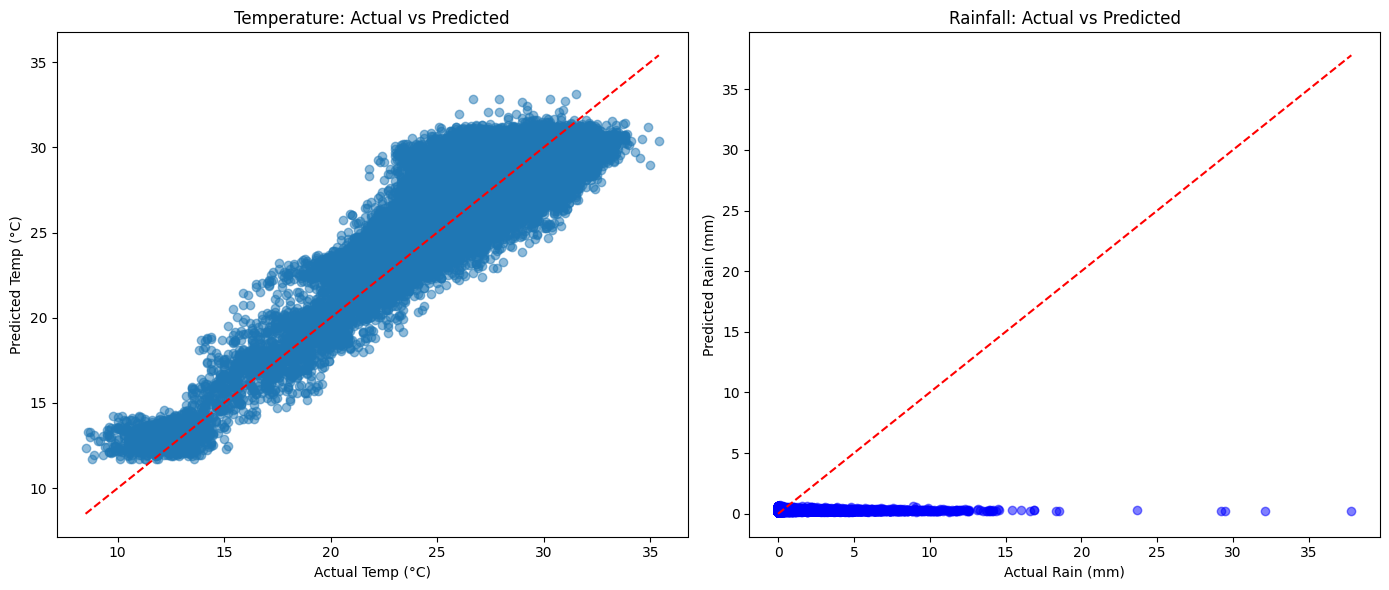

✅ Combined weather predictor saved: weather_predictor.pkl


In [33]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from lightgbm import LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor, Pool


class WeatherPredictor:
    def __init__(self):
        self.temperature_model = None
        self.rain_category_model = None
        self.rain_amount_model = None

    def categorize_rain(self, rain_mm):
        """Convert rainfall amount into category labels."""
        if rain_mm == 0:
            return 0  # No rain
        elif rain_mm <= 1.5:
            return 1  # Light
        else:
            return 2  # Moderate-Heavy

    def train(self, X_train, y_train_temp, y_train_rain,
              X_val, y_val_temp, y_val_rain, cat_features):

        # --- Train Temperature Model (LightGBM) ---
        self.temperature_model = LGBMRegressor(
            n_estimators=500,
            learning_rate=0.05,
            random_state=42
        )
        self.temperature_model.fit(
            X_train, y_train_temp,
            eval_set=[(X_val, y_val_temp)],
            eval_metric='l1',
            callbacks=[lgb.early_stopping(stopping_rounds=50)]
        )

        # --- Prepare category targets ---
        y_train_cat = y_train_rain.apply(self.categorize_rain)
        y_val_cat = y_val_rain.apply(self.categorize_rain)

        # --- Train Rainfall Category Model (CatBoost) ---
        train_pool_cat = Pool(X_train, y_train_cat, cat_features=cat_features)
        val_pool_cat = Pool(X_val, y_val_cat, cat_features=cat_features)

        self.rain_category_model = CatBoostClassifier(
            iterations=500,
            depth=8,
            learning_rate=0.05,
            loss_function='MultiClass',
            eval_metric='TotalF1',
            random_seed=42,
            verbose=False
        )
        self.rain_category_model.fit(
            train_pool_cat,
            eval_set=val_pool_cat,
            early_stopping_rounds=30
        )

        # --- Train Rainfall Amount Model (CatBoost Regression) ---
        train_pool_amt = Pool(X_train, y_train_rain, cat_features=cat_features)
        val_pool_amt = Pool(X_val, y_val_rain, cat_features=cat_features)

        self.rain_amount_model = CatBoostRegressor(
            iterations=500,
            depth=8,
            learning_rate=0.05,
            loss_function='RMSE',
            random_seed=42,
            verbose=False
        )
        self.rain_amount_model.fit(
            train_pool_amt,
            eval_set=val_pool_amt,
            early_stopping_rounds=30
        )

        # --- Evaluation ---
        self.evaluate(X_val, y_val_temp, y_val_rain)

    def evaluate(self, X_val, y_val_temp, y_val_rain):
        # Temp metrics
        y_pred_temp = self.temperature_model.predict(X_val)
        rmse_temp = np.sqrt(mean_squared_error(y_val_temp, y_pred_temp))
        mae_temp = mean_absolute_error(y_val_temp, y_pred_temp)
        r2_temp = r2_score(y_val_temp, y_pred_temp)

        # Rain category metrics
        y_val_cat = y_val_rain.apply(self.categorize_rain)
        y_pred_cat = self.rain_category_model.predict(X_val)
        print("\n🌧 Rainfall Category Prediction Report:")
        print(classification_report(y_val_cat, y_pred_cat, target_names=["No rain", "Light", "Moderate-Heavy"]))
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_val_cat, y_pred_cat))

        # Rain amount metrics
        y_pred_amt = self.rain_amount_model.predict(X_val)
        rmse_rain = np.sqrt(mean_squared_error(y_val_rain, y_pred_amt))
        mae_rain = mean_absolute_error(y_val_rain, y_pred_amt)
        r2_rain = r2_score(y_val_rain, y_pred_amt)

        # Display metrics
        print("\n📊 Temperature Model Performance:")
        print(f"RMSE: {rmse_temp:.3f}, MAE: {mae_temp:.3f}, R²: {r2_temp:.3f}")
        print("\n🌧 Rainfall Amount Model Performance:")
        print(f"RMSE: {rmse_rain:.3f}, MAE: {mae_rain:.3f}, R²: {r2_rain:.3f}")

        # Plots
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].scatter(y_val_temp, y_pred_temp, alpha=0.5)
        axes[0].plot([y_val_temp.min(), y_val_temp.max()],
                     [y_val_temp.min(), y_val_temp.max()],
                     'r--')
        axes[0].set_title("Temperature: Actual vs Predicted")
        axes[0].set_xlabel("Actual Temp (°C)")
        axes[0].set_ylabel("Predicted Temp (°C)")

        axes[1].scatter(y_val_rain, y_pred_amt, alpha=0.5, color='blue')
        axes[1].plot([y_val_rain.min(), y_val_rain.max()],
                     [y_val_rain.min(), y_val_rain.max()],
                     'r--')
        axes[1].set_title("Rainfall: Actual vs Predicted")
        axes[1].set_xlabel("Actual Rain (mm)")
        axes[1].set_ylabel("Predicted Rain (mm)")

        plt.tight_layout()
        plt.show()

    def predict(self, X):
        temp_pred = self.temperature_model.predict(X)
        cat_pred = self.rain_category_model.predict(X)
        amt_pred = self.rain_amount_model.predict(X)
        return temp_pred, cat_pred, amt_pred


# --- Usage ---
predictor = WeatherPredictor()
predictor.train(X_train, y_train_temp, y_train_rain, X_val, y_val_temp, y_val_rain, cat_features=['district'])
joblib.dump(predictor, "weather_predictor.pkl")
print("✅ Combined weather predictor saved: weather_predictor.pkl")
